# Model-Specific Input Data Preprocessing in CONFLUENCE

## Introduction

This notebook covers the model-specific preprocessing steps for input data in CONFLUENCE. After completing the model-agnostic preprocessing, we now focus on tailoring our data to the specific requirements of the chosen hydrological model (e.g., SUMMA, HYPE, or MESH).

Key aspects covered in this notebook include:

1. Formatting data according to the chosen model's input specifications
2. Generating model-specific configuration files
3. Preparing initial conditions and parameter files
4. Creating forcing data in the required format and resolution

In this notebook we ensure that our preprocessed data is compatible with the chosen hydrological model. By the end of this process, you will have a complete set of input files ready for model initialization and simulation.

## First we import the libraries and functions we need

In [1]:
import sys
from pathlib import Path
from typing import Dict, Any
import logging
import yaml # type: ignore

current_dir = Path.cwd()
parent_dir = current_dir.parent.parent
sys.path.append(str(parent_dir))

#from utils.dataHandling_utils.specificPreProcessor_util import SummaPreProcessor_spatial, flashPreProcessor # type: ignore
from utils.models_utils.summa_utils import SummaPreProcessor_spatial # type: ignore
from utils.models_utils.mizuroute_utils import MizuRoutePreProcessor

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

## Check configurations

Now we should print our configuration settings and make sure that we have defined all the settings we need. 

In [2]:
config_path = Path('../../0_config_files/config_active.yaml')
with open(config_path, 'r') as config_file:
    config = yaml.safe_load(config_file)
    print(f"FORCING_DATASET: {config['FORCING_DATASET']}")
    print(f"EASYMORE_CLIENT: {config['EASYMORE_CLIENT']}")
    print(f"FORCING_VARIABLES: {config['FORCING_VARIABLES']}")
    print(f"EXPERIMENT_TIME_START: {config['EXPERIMENT_TIME_START']}")
    print(f"EXPERIMENT_TIME_END: {config['EXPERIMENT_TIME_END']}")

FORCING_DATASET: ERA5
EASYMORE_CLIENT: easymore cli
FORCING_VARIABLES: longitude,latitude,time,LWRadAtm,SWRadAtm,pptrate,airpres,airtemp,spechum,windspd
EXPERIMENT_TIME_START: 2008-01-01 00:00
EXPERIMENT_TIME_END: 2022-12-31 23:00


## Define default paths

Now let's define the paths to data directories before we run the pre processing scripts and create the containing directories

In [ ]:
# Main project directory
data_dir = config['SYMFLUENCE_DATA_DIR']
project_dir = Path(data_dir) / f"domain_{config['DOMAIN_NAME']}"

# Data directoris
model_input_dir = project_dir / f"{config['HYDROLOGICAL_MODEL']}_input"

# Make sure the new directories exists
model_input_dir.mkdir(parents = True, exist_ok = True)

## Create model configuration files

In [23]:
# Initialize model specific preprocessors

if config['HYDROLOGICAL_MODEL'] == 'SUMMA':
    ssp = SummaPreProcessor_spatial(config, logger)
    ssp.run_preprocessing()

    if config['DOMAIN_DEFINITION_METHOD'] != 'lumped': # lumped domain definition has no routing
        mp = MizuRoutePreProcessor(config,logger)
        mp.run_preprocessing()
    
    
elif config['HYDROLOGICAL_MODEL'] == 'FLASH':
    ssp = flashPreProcessor(config, logger)

2025-03-28 09:23:23,937 - INFO - Starting SUMMA spatial preprocessing
2025-03-28 09:23:23,938 - INFO - Starting forcing data processing
2025-03-28 09:23:23,939 - INFO - Starting to apply temperature lapse rate and add data step
2025-03-28 09:23:23,938 - INFO - Starting forcing data processing
2025-03-28 09:23:23,939 - INFO - Starting to apply temperature lapse rate and add data step
2025-03-28 09:23:23,948 - INFO - Processing Wolverine_ERA5_remapped_domain_Wolverine_ERA5_merged_200801.nc
2025-03-28 09:23:24,222 - INFO - Processing Wolverine_ERA5_remapped_domain_Wolverine_ERA5_merged_200802.nc
2025-03-28 09:23:24,315 - INFO - Processing Wolverine_ERA5_remapped_domain_Wolverine_ERA5_merged_200803.nc
2025-03-28 09:23:24,412 - INFO - Processing Wolverine_ERA5_remapped_domain_Wolverine_ERA5_merged_200804.nc
2025-03-28 09:23:24,522 - INFO - Processing Wolverine_ERA5_remapped_domain_Wolverine_ERA5_merged_200805.nc
2025-03-28 09:23:24,612 - INFO - Processing Wolverine_ERA5_remapped_domain_Wolv

In [ ]:
# plot this data against observations and calculated a weather correction slope and intercept by elevation
# basic functions
import numpy as np
import netCDF4 as nc4
import pandas as pd
import shutil
import rasterio
import geopandas as gpd
from rasterio.transform import xy
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import CRS
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from dateutil import parser
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

data_dir = config['SYMFLUENCE_DATA_DIR']
domain_name = config['DOMAIN_NAME']
project_dir = Path(data_dir) / f"domain_{config['DOMAIN_NAME']}"
attribute_name = config['SETTINGS_SUMMA_ATTRIBUTES']
attribute_path =  project_dir / 'settings/SUMMA'/ attribute_name
forcing_path = project_dir / 'forcing/SUMMA_input'

summa_vars =  config['FORCING_VARIABLES'] #time, LWRadAtm (W m-2), SWRadAtm (W m-2) , pptrate (kg m-2 s-1), airpres (Pa),airtemp (K), spechum (kg/kg), windspd (m s-1)
summa_vars_met = summa_vars.split(',')
time_step = config['FORCING_TIME_STEP_SIZE'] # in s
lapse_rate = config['LAPSE_RATE'] # in K m-1, was applied if APPLY_LAPSE_RATE is True
# note, this assumes fileManager has has tmZoneInfo           'utcTime'

summa_vars_met = summa_vars.split(',')
# remove latitude, longitude and spaces
summa_vars_met = [var.strip() for var in summa_vars_met]
summa_vars_met = [var for var in summa_vars_met if var not in ['time', 'latitude', 'longitude']]

In [9]:
# from the attribute file, get the elevation data
with xr.open_dataset(attribute_path) as attr:
    all_elev = attr['elevation'].values

# for each variable that is not latitude, longitude, or time, get all data
all_time = []
all_data = {}

forcing_files = sorted(forcing_path.glob("*.nc"))
for file in forcing_files:
    with xr.open_dataset(file) as ds:
        if 'time' in ds.variables:
            time = ds['time'].values
            all_time.append(time)
        else:
            print(f"'time' variable not found in {file.name}")
            continue
        for var in summa_vars_met:
            if var in ds.variables:
                # Store as array with dimensions [time, HRU (elevation)]
                data = ds[var].values
                if var not in all_data:
                    all_data[var] = data
                else:
                    # Concatenate along time axis
                    all_data[var] = np.concatenate([all_data[var], data], axis=0)

# Flatten all_time to a single array if needed
all_time_flat = np.concatenate(all_time)

ds_summa = xr.Dataset(
    {var: (["time", "elevation"], all_data[var]) for var in all_data},
    coords={
        "time": all_time_flat,
        "elevation": all_elev
    }
)
        
# earliest date in forcing data
time0 = np.datetime64(all_time_flat[0], 'ns')
year0 = int(str(time0).split('-')[0])
month0 = int(str(time0).split('-')[1])
# latest date in forcing data
time1 = np.datetime64(all_time_flat[-1], 'ns')
year1 = int(str(time1).split('-')[0])
month1 = int(str(time1).split('-')[1])

In [10]:
comp_folder = project_dir / 'USGSweatherData'
level= 'LVL2' # level folder in forcing directory
# elevation directory in forcing directory, take all directories
elev_dirs = sorted([
    d for d in comp_folder.glob('*')
    if d.is_dir() and d.name.isdigit()
])
if domain_name == 'Gulkana':
    precipfac =1.48
elif domain_name == 'Wolverine':
    precipfac =2.28
else:
    precipfac =1.0

# Alaska time zone
AKST = pytz.timezone('America/Anchorage')

def local_to_utc(local_str, first_time):
    # Replace '/' with '-' for compatibility
    dt_naive = parser.parse(local_str.replace('/', '-'))
    try:
        # Try localizing, let pytz handle ambiguous times (fall back)
        dt_local = AKST.localize(dt_naive, is_dst=None)
    except pytz.AmbiguousTimeError:
        # If ambiguous (fall back), pick standard time if second time seeing time (is_dst=False)
        dt_local = AKST.localize(dt_naive, is_dst=first_time)
        first_time = False  # after first occurrence, set to False
    dt_utc = dt_local.astimezone(pytz.UTC)
    return np.datetime64(dt_utc.strftime('%Y-%m-%dT%H:%M')), first_time

def aggregate_every_n(arr, n, func=np.nanmean):
    return np.array([func(arr[i:i+n]) for i in range(0, len(arr), n)])

def _get_col(data_arr, candidates):
    for name in candidates:
        if name in data_arr.dtype.names:
            return np.array([row[name] for row in data_arr])
    return np.full(len(data_arr), np.nan)

In [11]:
# create empty dataset for comparison data
comp_data = {var: [] for var in summa_vars_met}
comp_elev = np.array([int(ed.name) for ed in elev_dirs])

# Create an empty dataset with the same timestamps and variables as ds_summa, but for new elevations
comp_data = {
    var: (["time", "elevation"], np.full((ds_summa.dims["time"], len(comp_elev)), np.nan))
    for var in ds_summa.data_vars
}

ds_comp = xr.Dataset(
    comp_data,
    coords={
        "time": ds_summa["time"].values,
        "elevation": comp_elev
    }
)

for elev_dir in elev_dirs:
    level_dir = elev_dir / level
    comp_files = sorted(level_dir.glob('*_15min_*.csv'))
    for file in comp_files:
        # extract year and elevation from filename
        parts = file.name.split('_')
        year_str = parts[3][:4]
        elev_str = parts[0][-4:]
        # if first character is a letter, remove it
        if elev_str[0].isalpha():
            elev_str = elev_str[1:]
        elev_comp = int(elev_str)
        year_comp = int(year_str) # this is data from 10-01 00:00 of previous year to 09-30 23:00 month of this year in local time (UTC-8)
        # only process files that overlap with the model experiment time
        if (year_comp == year0 and month0 < 10) or (year_comp > year0 and year_comp < year1+1) or (year_comp == year1+1 and month1 > 9):
            # read the file, skipping the first row
            data = np.genfromtxt(file, delimiter=',', names=True, dtype=None, encoding=None)

            # extract the variables of interest
            # time, UTC and local
            if 'UTC_time' in data.dtype.names:
                time_comp = np.array([
                    np.datetime64(parser.parse(row['UTC_time'].replace('/', '-')).strftime('%Y-%m-%dT%H:%M'))
                    for row in data
                ])
                print("processing UTC times for WY", str(year_comp), "for elevation", str(elev_comp))
            elif 'local_time' in data.dtype.names: # only wolverine 1420
                first_time = True  # flag to handle ambiguous times only for the first occurrence
                time_comp = []
                for row in data:
                    utc_time, first_time = local_to_utc(row['local_time'], first_time)
                    utc_time = utc_time + np.timedelta64(15, 'm') # add 15 minutes to align with rest of data input
                    time_comp.append(utc_time)
                time_comp = np.array(time_comp)         
                print("processing local times for WY", str(year_comp), " for elevation", str(elev_comp))
            else:
                raise KeyError(f"Neither 'UTC_time' nor 'local_time' found in data columns for file {file.name}.")
            
            temp_comp = _get_col(data, ['site_temp', 'TPassive', 'TAspirated', 'TPassive1', 'TAspirated1','TPassive2', 'TAspirated2'])
            precip_weighing = _get_col(data, ['Precip_Weighing_Incremental'])
            precip_stage = _get_col(data, ['Precip_Stage_Incremental'])
            precip_disdrom  = _get_col(data, ['Precip_Disdrometer_Incremental'])
            wind_comp = _get_col(data, ['WindSpeed'])
            sw_rad_comp = _get_col(data, ['ShortwaveIn', 'RadiationIn'])
            lw_rad_comp = _get_col(data, ['LongwaveIn', 'LWRadiationIn'])
            rh_comp = _get_col(data, ['RelHum'])
            pres_comp = _get_col(data, ['Barom'])
            
            # combine precip estimates, use weighing if available, otherwise stage
            precip_comp = np.where(~np.isnan(precip_weighing), precip_weighing, precip_stage*precipfac)
            # precip from disdrometer is generally very noisy, use as last resort
            precip_comp = np.where(~np.isnan(precip_comp), precip_comp, precip_disdrom)

            # get minute time starts on and make start on :15 if hrly, etc
            first_minute = pd.to_datetime(str(time_comp[0] - np.timedelta64(15, 'm'))).minute
            first_hr = pd.to_datetime(str(time_comp[0] - np.timedelta64(15, 'm'))).hour
            if time_step % 900 == 0 and 3600*24 % time_step == 0:
                n = time_step // 900
            else:
                raise NotImplementedError("Only time steps that are multiples of 900s (15-min) and divisors of days are supported.")

            # Find the offset in minutes from midnight
            offset_min = first_hr * 60 + first_minute

            # Find the index of the first time that aligns with the desired interval
            start = (n - ((offset_min % (n * 15)) // 15)) % n

            # data generally start at 00:15 local time on first day, and end at 23:30 (missing last 2 values)
            # Subsample time to match the number of chunks
            num_chunks = int(np.ceil((len(temp_comp) - start) / n))
            time_comp = np.array([time_comp[start + i*n] for i in range(num_chunks)]) - np.timedelta64(15, 'm')

            # Aggregate variables
            temp_comp = aggregate_every_n(temp_comp[start:], n, np.nanmean)
            precip_comp = aggregate_every_n(precip_comp[start:], n, np.nansum)
            wind_comp = aggregate_every_n(wind_comp[start:], n, np.nanmean)
            sw_rad_comp = aggregate_every_n(sw_rad_comp[start:], n, np.nanmean)
            lw_rad_comp = aggregate_every_n(lw_rad_comp[start:], n, np.nanmean)
            rh_comp = aggregate_every_n(rh_comp[start:], n, np.nanmean)
            pres_comp = aggregate_every_n(pres_comp[start:], n, np.nanmean)

            # only keep data within the model experiment time and transform them to match summa units
            mask = (time_comp >= time0) & (time_comp <= time1)
            time_comp = time_comp[mask]
            temp_comp = temp_comp[mask]+273.15 # from C to K
            precip_comp = precip_comp[mask] / 3600.0  # from mm hr-1 to kg m-2 s-1 assuming a water density of 1000 kg m-3
            wind_comp = wind_comp[mask]
            sw_rad_comp = sw_rad_comp[mask]
            lw_rad_comp = lw_rad_comp[mask]
            pres_comp = pres_comp[mask] * 1000.0 # from kPa to Pa
            rh_comp = rh_comp[mask]
            # compute spechum from rh, temp, pres
            es = 610.8 * np.exp((17.27 * (temp_comp - 273.15)) / (temp_comp - 35.85)) # saturation vapor pressure in Pa
            ea = (rh_comp / 100.0) * es # actual vapor pressure in Pa
            w = 0.622 * ea / (pres_comp - ea) # water vapor mixing ratio in kg/kg
            spechum_comp = w/ (1.0 + w) # kg/kg

            # Find the index of this elevation in the ds_comp dataset
            elev_index = np.where(ds_comp['elevation'].values == elev_comp)[0][0]  # get the integer value

            # Assign the data to the correct elevation and time indices
            if time_comp[0] >= ds_comp['time'].values[0]:
                time_index0 = np.where(ds_comp['time'].values == time_comp[0])[0][0]   # get the integer value
                ind0 = 0
            else:
                time_index0 = 0
                ind0 = np.where(time_comp == ds_comp['time'].values[0])[0][0]
            if time_comp[-1] <= ds_comp['time'].values[-1]:
                time_index1 = np.where(ds_comp['time'].values == time_comp[-1])[0][0]  # get the integer value
                ind1 = len(time_comp) - 1
            else:
                time_index1 = ds_comp.dims['time'] - 1
                ind1 = np.where(time_comp == ds_comp['time'].values[-1])[0][0]

            ds_comp['airtemp'].values[time_index0:time_index1+1, elev_index] = temp_comp[ind0:ind1+1]
            ds_comp['pptrate'].values[time_index0:time_index1+1, elev_index] = precip_comp[ind0:ind1+1]
            ds_comp['windspd'].values[time_index0:time_index1+1, elev_index] = wind_comp[ind0:ind1+1]
            ds_comp['SWRadAtm'].values[time_index0:time_index1+1, elev_index] = sw_rad_comp[ind0:ind1+1]
            ds_comp['LWRadAtm'].values[time_index0:time_index1+1, elev_index] = lw_rad_comp[ind0:ind1+1]
            ds_comp['spechum'].values[time_index0:time_index1+1, elev_index] = spechum_comp[ind0:ind1+1]
            ds_comp['airpres'].values[time_index0:time_index1+1, elev_index] = pres_comp[ind0:ind1+1]

/var/folders/vg/2cv5b92d4216qkxz87hgmv7r0000kp/T/ipykernel_98638/2825817067.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  var: (["time", "elevation"], np.full((ds_summa.dims["time"], len(comp_elev)), np.nan))
/var/folders/vg/2cv5b92d4216qkxz87hgmv7r0000kp/T/ipykernel_98638/4148415656.py:32: RuntimeWarning: Mean of empty slice
  return np.array([func(arr[i:i+n]) for i in range(0, len(arr), n)])


processing local times for WY 2012  for elevation 1420
processing local times for WY 2013  for elevation 1420
processing local times for WY 2014  for elevation 1420
processing local times for WY 2015  for elevation 1420
processing local times for WY 2016  for elevation 1420
processing local times for WY 2017  for elevation 1420
processing local times for WY 2018  for elevation 1420
processing local times for WY 2019  for elevation 1420
processing UTC times for WY 2008 for elevation 990
processing UTC times for WY 2009 for elevation 990
processing UTC times for WY 2010 for elevation 990
processing UTC times for WY 2011 for elevation 990
processing UTC times for WY 2012 for elevation 990
processing UTC times for WY 2013 for elevation 990
processing UTC times for WY 2014 for elevation 990
processing UTC times for WY 2015 for elevation 990
processing UTC times for WY 2016 for elevation 990
processing UTC times for WY 2017 for elevation 990
processing UTC times for WY 2018 for elevation 990

Variable: LWRadAtm: Not enough variability to compute regression
Variable: SWRadAtm: Not enough variability to compute regression
Variable: pptrate, Slope: 1.000, Intercept: 3.14866e-05, R²=0.063, N=2476
Variable: airpres: Not enough variability to compute regression
Variable: airtemp, Slope: 1.000, Intercept: 2.95445, R²=0.946, N=52091
Variable: spechum: Not enough variability to compute regression
Variable: windspd, Slope: 1.000, Intercept: -0.276328, R²=0.698, N=18709


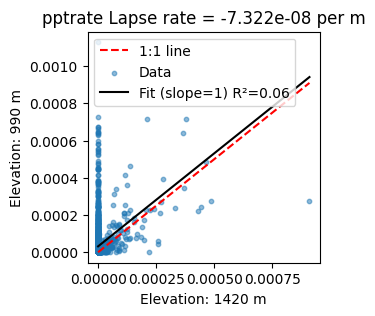

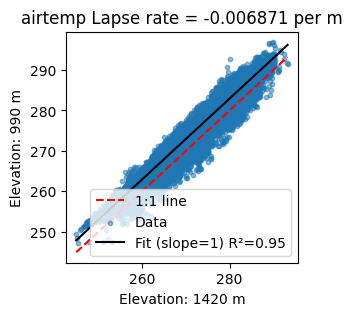

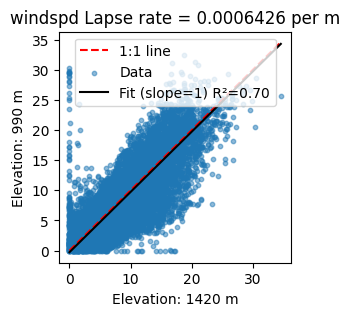

In [12]:
# build daily precip DataArray for use in lapse calculations (daily mean to match other uses)
times = pd.to_datetime(ds_comp['time'].values)
pptrate_hrly = ds_comp['pptrate'].values  # [time, elev]
daily_precip_list = []
for i in range(pptrate_hrly.shape[1]):
    df = pd.DataFrame({'precip': pptrate_hrly[:, i]}, index=times)
    daily = df.resample('1D').mean()
    daily_precip_list.append(daily['precip'].values)
daily_precip = np.stack(daily_precip_list, axis=1)
daily_times = pd.date_range(times[0].normalize(), times[-1].normalize(), freq='1D')
pptrate_daily = xr.DataArray(daily_precip, coords={'time': daily_times, 'elevation': ds_comp['elevation'].values}, dims=['time', 'elevation'])

lapse_vars = {}

for var in summa_vars_met:
    if var == 'pptrate': # --- special case: precip use daily aggregated values ---
        vars_arr = pptrate_daily
    else:
        vars_arr = ds_comp[var]

    elevs = vars_arr['elevation'].values
    vals0 = vars_arr.values[:, 0]
    vals1 = vars_arr.values[:, 1]
    
    valid = ~np.isnan(vals0) & ~np.isnan(vals1)
    if np.sum(valid) >= 2:
        X = vals0[valid]        # 1D
        y = vals1[valid]

        # Fit intercept only with slope fixed at 1: y = 1*X + b  =>  b = mean(y - X)
        intercept = np.nanmean(y - X)
        slope = 1.0
        y_pred = X + intercept

        # performance
        r2 = r2_score(y, y_pred)

        # convert intercept to lapse per meter (difference / dz)
        dz = elevs[1] - elevs[0] if elevs.size > 1 else np.nan
        lapse_rate = intercept / dz if (dz != 0 and not np.isnan(dz)) else np.nan

        plt.figure(figsize=(3, 3))
        plt.plot([np.nanmin(X), np.nanmax(X)], [np.nanmin(X), np.nanmax(X)], 'r--', label='1:1 line')
        plt.scatter(X, y, s=10, alpha=0.5, label='Data')
        xs_sorted = np.linspace(np.nanmin(X), np.nanmax(X), 100)
        plt.plot(xs_sorted, xs_sorted + intercept, 'k-', label=f'Fit (slope=1) R²={r2:.2f}')
        plt.title(f"{var} Lapse rate = {lapse_rate:.4g} per m")
        plt.xlabel(f"Elevation: {elevs[0]} m")
        plt.ylabel(f"Elevation: {elevs[1]} m")
        plt.legend()
        print(f"Variable: {var}, Slope: {slope:.3f}, Intercept: {intercept:.6g}, R²={r2:.3f}, N={np.sum(valid)}")
        lapse_vars[var] = lapse_rate
    else:
        print(f"Variable: {var}: Not enough variability to compute regression")
        lapse_vars[var] = np.nan

Variable: LWRadAtm, Not enough data at any elevation for regression.
Variable: SWRadAtm, linear fit R² = 0.7673, slope=0.924074, intercept=0.0, N=51183
Variable: SWRadAtm, linear fit R² = 0.7617, slope=0.942102, intercept=0.0, N=51183
Variable: SWRadAtm, linear fit R² = 0.7623, slope=0.940046, intercept=0.0, N=51183


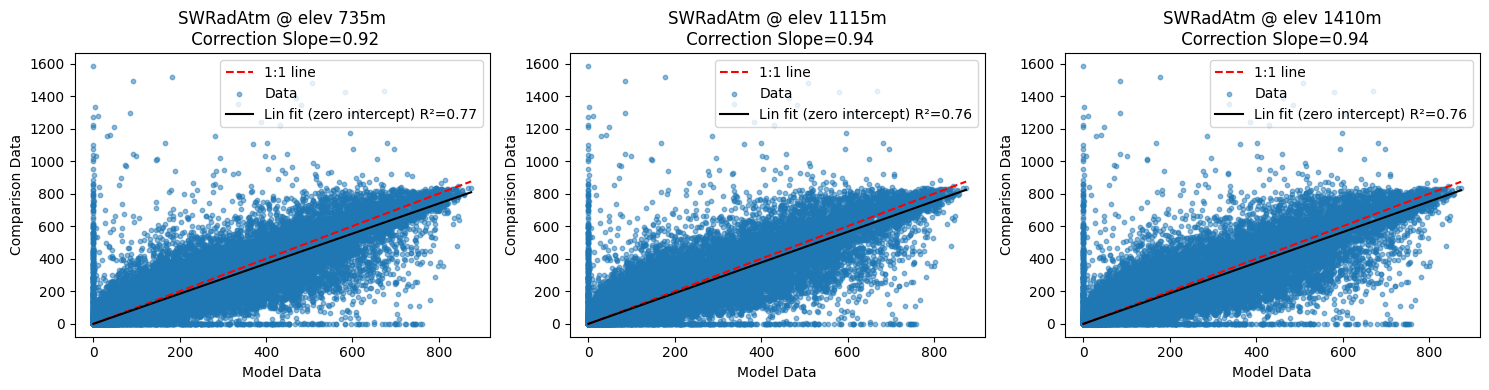

Variable: pptrate, linear fit R² = 0.3413, slope=0.404931, intercept=0.0, N=5479
Variable: pptrate, linear fit R² = 0.3550, slope=0.31913, intercept=0.0, N=5479
Variable: pptrate, linear fit R² = 0.2985, slope=0.259835, intercept=0.0, N=5479


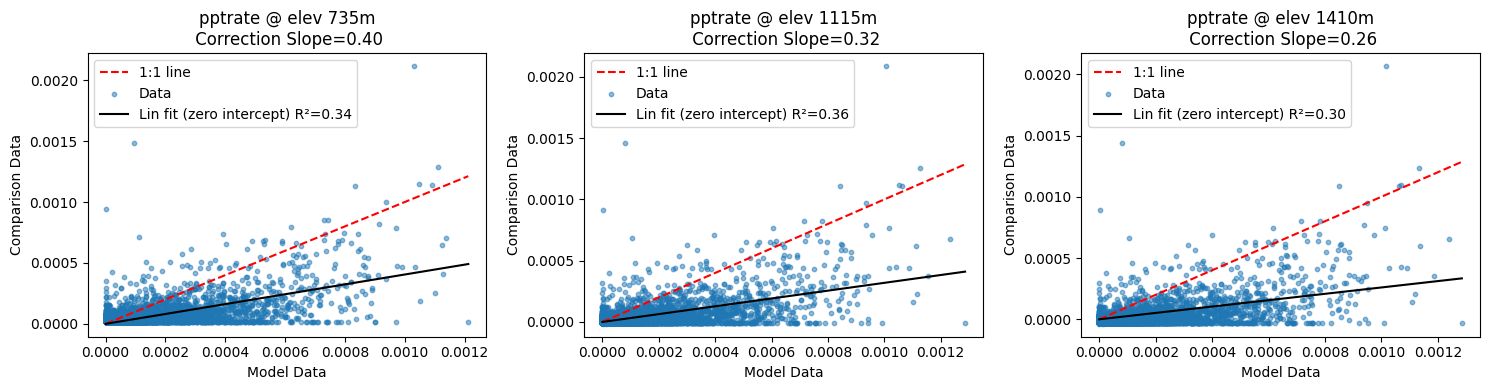

Variable: airpres, linear fit R² = 0.9958, slope=1.00782, intercept=0.0, N=33980
Variable: airpres, linear fit R² = 0.9866, slope=0.959424, intercept=0.0, N=33980
Variable: airpres, linear fit R² = 0.9697, slope=0.92369, intercept=0.0, N=33980


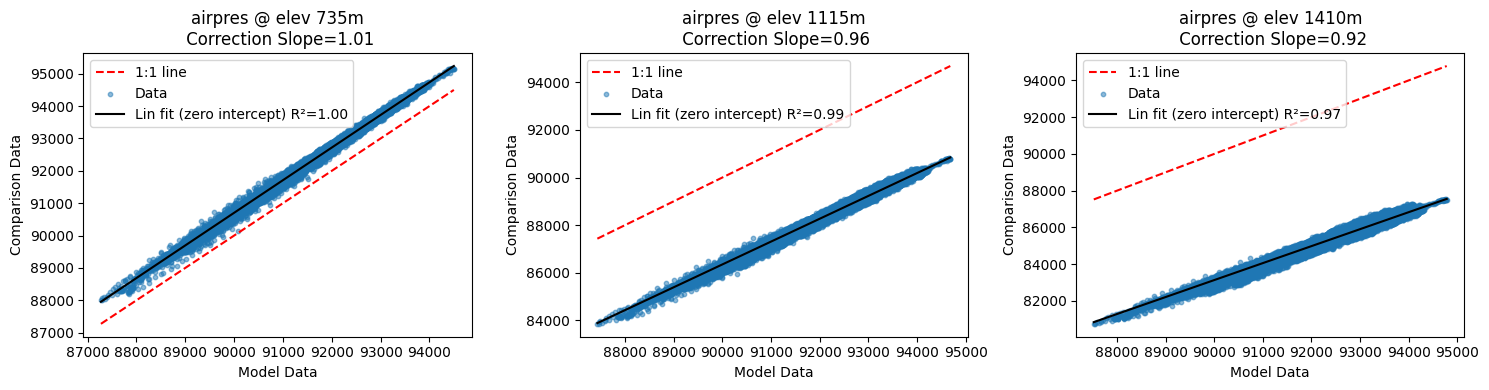

Variable: airtemp, linear fit R² = 0.8330, slope=1.00656, intercept=0.0, N=122458
Variable: airtemp, linear fit R² = 0.7968, slope=1.00171, intercept=0.0, N=122458
Variable: airtemp, linear fit R² = 0.7966, slope=1.0014, intercept=0.0, N=122458


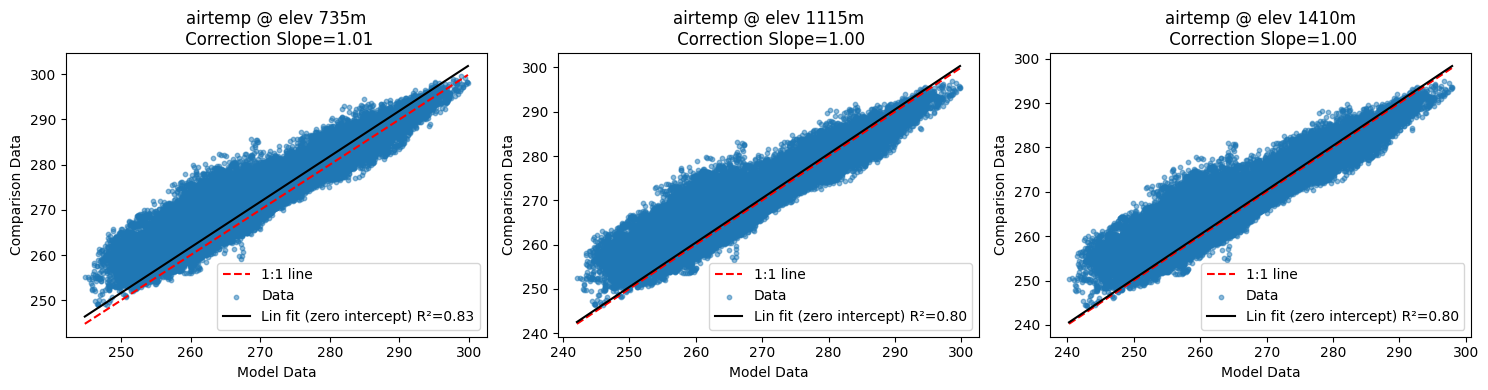

Variable: spechum, linear fit R² = 0.9219, slope=0.897899, intercept=0.0, N=33980
Variable: spechum, linear fit R² = 0.9095, slope=0.882272, intercept=0.0, N=33980
Variable: spechum, linear fit R² = 0.9111, slope=0.881427, intercept=0.0, N=33980


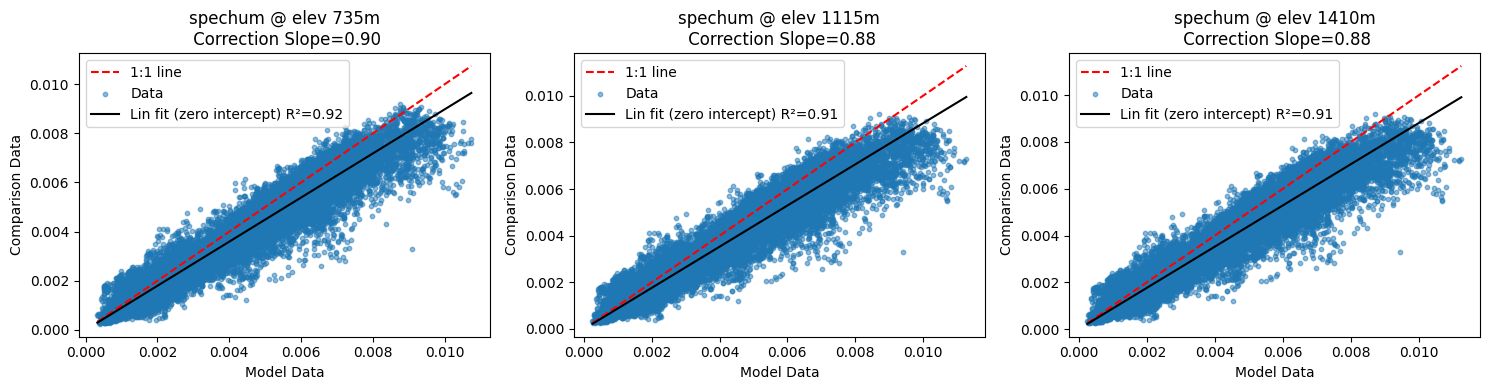

Variable: windspd, linear fit R² = 0.5084, slope=5.97437, intercept=0.0, N=121255
Variable: windspd, linear fit R² = 0.4601, slope=6.79417, intercept=0.0, N=121255
Variable: windspd, linear fit R² = 0.4594, slope=6.92304, intercept=0.0, N=121255


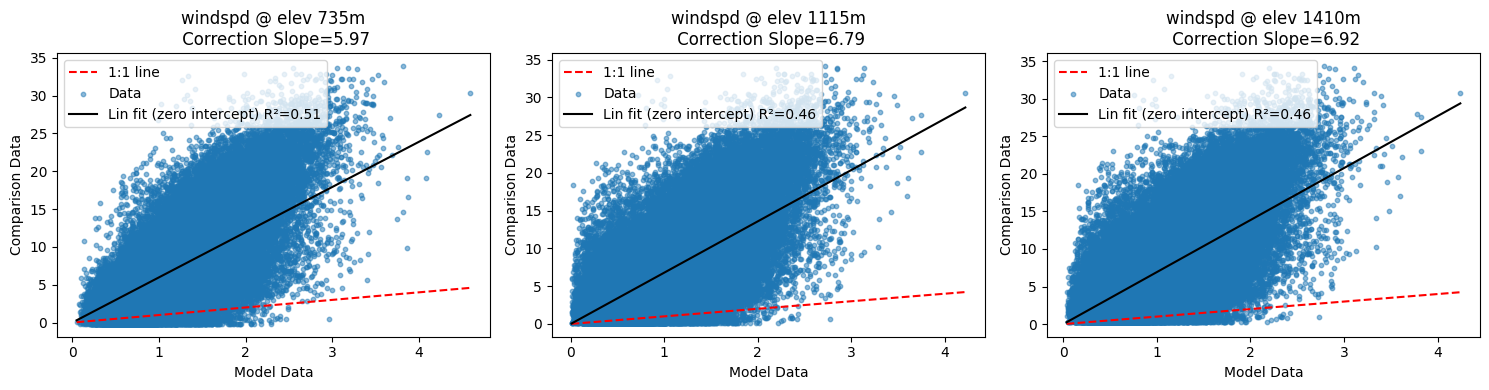

In [ ]:
# correct main comp data to elevations of model HRUs if possible and make linear regressions on variables at each elevation
correction_vars = {}
for var in summa_vars_met:
    
    if var == 'pptrate': # --- special case: precip use daily aggregated values ---
        # comp: pptrate_daily (created earlier), model: daily mean of ds_summa pptrate
        comp_arr = pptrate_daily.values  # shape: [time_daily, elevation_comp]
        model_arr = ds_summa[var].resample(time='1D').mean().values  # shape: [time_daily, elevation_model]
    else:
        comp_arr = ds_comp[var].values  # shape: [time, elevation_comp]
        model_arr = ds_summa[var].values  # shape: [time, elevation_model]
    comp_elevs = ds_comp['elevation'].values

    # pick main elevation from comp daily (most non-nan)
    max_data = 0
    main_elev = comp_elevs[0]
    for ie, elev in enumerate(comp_elevs):
        n_data = np.sum(~np.isnan(comp_arr[:, ie]))
        if n_data > max_data:
            max_data = n_data
            main_elev = elev
    if max_data < 2:
        print(f"Variable: {var}, Not enough data at any elevation for regression.")
        continue

    fig, axes = plt.subplots(1, len(ds_summa['elevation'].values), figsize=(5 * len(ds_summa['elevation'].values), 4), squeeze=False)
    for idx, elev in enumerate(ds_summa['elevation'].values):
        hru = idx
        # apply lapse correction to comp (if available)
        if not np.isnan(lapse_vars.get(var, np.nan)):
            dz = elev - main_elev
            correction = lapse_vars[var] * dz
            comp_data = comp_arr[:, np.where(comp_elevs == main_elev)[0][0]] + correction
        elif var == 'airpres':
            dz = elev - main_elev
            g = 9.80665         # gravity (m/s^2)
            R = 287.05          # gas constant for dry air (J/kg/K)
            L = lapse_vars.get('airtemp', -0.0065)
            # pressure at main elevation (Pa)

            p_main = comp_arr[:, np.where(comp_elevs == main_elev)[0][0]]
            T_main = ds_comp['airtemp'].values[:, np.where(comp_elevs == main_elev)[0][0]]
            factor = 1.0 + (L * dz) / T_main # = T_target / T_main

            # hypsometric / lapse-rate form: p(z) = p0 * factor^(g/(R*L))
            p_target = p_main * factor ** (g / (R * -L))
            correction = p_target - p_main
            comp_data = p_main + correction
        else:
            comp_data = comp_arr[:, np.where(comp_elevs == main_elev)[0][0]]

        model_data = model_arr[:, idx]
        valid = ~np.isnan(model_data) & ~np.isnan(comp_data)
        ax = axes[0, idx]

        if np.sum(valid) >= 2:
            X = model_data[valid].reshape(-1, 1)  # model on x-axis
            y = comp_data[valid]                 # comparison on y-axis
            reg = LinearRegression(fit_intercept=False).fit(X, y)  # force zero intercept
            y_pred = reg.predict(X)
            r2 = r2_score(y, y_pred)
            slope = reg.coef_[0]
            intercept = 0.0
            ax.plot([np.nanmin(X), np.nanmax(X)], [np.nanmin(X), np.nanmax(X)], 'r--', label='1:1 line')

            ax.scatter(X, y, s=10, alpha=0.5, label='Data')
            xs_sorted = np.sort(X.flatten())
            ax.plot(xs_sorted, reg.predict(xs_sorted.reshape(-1, 1)), 'k-', label=f'Lin fit (zero intercept) R²={r2:.2f}')
            ax.set_title(f"{var} @ elev {elev:.0f}m\n Correction Slope={slope:.2f}")
            ax.set_xlabel('Model Data')
            ax.set_ylabel('Comparison Data')
            ax.legend()
            print(f"Variable: {var}, linear fit R² = {r2:.4f}, slope={reg.coef_[0]:.6g}, intercept=0.0, N={np.sum(valid)}")
            correction_vars[(var, hru)] = reg.coef_[0]
        else:
            ax.set_title(f"{var} @ elev {elev}m\nNot enough data")
            ax.axis('off')
            print(f"Variable: {var}, Elevation: {elev} m, Not enough valid data for regression.")
            correction_vars[(var, hru)] = 1.0
    plt.tight_layout()
    plt.show()

In [ ]:
# make a new folder and save corrected model forcing data
# Reduce wind speed corrections to 1/3 to avoid too strong correction
correction_vars_use = correction_vars.copy()
for key in list(correction_vars.keys()):
    if key[0] == 'windspd':
        correction_vars_use[key] = max(1.0,correction_vars[key] / 3.5)
corrected_forcing_path = forcing_path / 'corrected_forcing'
corrected_forcing_path.mkdir(parents=True, exist_ok=True)
do_vars = ['LWRadAtm', 'SWRadAtm', 'airpres', 'airtemp', 'spechum', 'windspd'] #['LWRadAtm', 'SWRadAtm', 'pptrate', 'airpres', 'airtemp', 'spechum', 'windspd']
do_vars = summa_vars_met # apply correction to all variables
# open every forcing file again, apply correction and save to new file
for file in forcing_files:
    with xr.open_dataset(file) as ds:
        ds_corrected = ds.copy()
        for var in summa_vars_met:
            for ie, hru in enumerate(ds['hru'].values):
                if var in do_vars: ds_corrected[var].values[:, ie] = ds[var].values[:, ie] * correction_vars_use.get((var, hru), 1.0)
                if var not in do_vars: ds_corrected[var].values[:, ie] = ds[var].values[:, ie]
        # save to new file in corrected_forcing folder
        corrected_file = corrected_forcing_path / file.name
        ds_corrected.to_netcdf(corrected_file)
        print(f"Saved corrected forcing data to {corrected_file}")

Saved corrected forcing data to /Users/amedin/Research/Confluence/CONFLUENCE_data/domain_Wolverine/forcing/SUMMA_input/corrected_forcing/Wolverine_ERA5_remapped_domain_Wolverine_ERA5_merged_200801.nc
Saved corrected forcing data to /Users/amedin/Research/Confluence/CONFLUENCE_data/domain_Wolverine/forcing/SUMMA_input/corrected_forcing/Wolverine_ERA5_remapped_domain_Wolverine_ERA5_merged_200802.nc
Saved corrected forcing data to /Users/amedin/Research/Confluence/CONFLUENCE_data/domain_Wolverine/forcing/SUMMA_input/corrected_forcing/Wolverine_ERA5_remapped_domain_Wolverine_ERA5_merged_200803.nc
Saved corrected forcing data to /Users/amedin/Research/Confluence/CONFLUENCE_data/domain_Wolverine/forcing/SUMMA_input/corrected_forcing/Wolverine_ERA5_remapped_domain_Wolverine_ERA5_merged_200804.nc
Saved corrected forcing data to /Users/amedin/Research/Confluence/CONFLUENCE_data/domain_Wolverine/forcing/SUMMA_input/corrected_forcing/Wolverine_ERA5_remapped_domain_Wolverine_ERA5_merged_200805.nc


## Make Glacier attibutes and initial conditions (cold state) files

In [ ]:
def getNetCDFData(fn, varname):
    """Read <varname> variables available to be mapped from NetCDF <fn> """
    f = nc4.Dataset(fn,'r')
    data = f.variables[varname][:]
    f.close()
    return data

def getOutputPolyIDs(nc_file):
    outPolyIDs  = getNetCDFData(nc_file, 'hruId')    
    hru_elev = getNetCDFData(nc_file, 'elevation')
    hru_area = getNetCDFData(nc_file, 'HRUarea')
    gruIDs = getNetCDFData(nc_file, 'gruId')
    hru2gru = getNetCDFData(nc_file, 'hru2gruId')
    print("read data from attribute file")
    return outPolyIDs,hru_elev,hru_area, gruIDs,hru2gru

# write gru, variables to netcdf output file
def writeNC_state_vars_GRU(nc_out, newVarName, newVarType, newVarVals):
    """ Write <vars>[gru] array in netCDF4 file,<fn> and variable of
        <varname> """
    print("adding attribute data")
    ncvar = nc_out.createVariable(newVarName, newVarType, ('gru',),fill_value='-999')    
    ncvar[:] = newVarVals   # store data in netcdf file

# write gru nonscalar variables to netcdf output file
def writeNC_state_vars_GRU_VEC(nc_out, newVarName, newVarDim, newVarType, newVarVals):
    """ Write <vars>[gru] array in netCDF4 file,<fn> and variable of
        <varname> """
    print("adding GRU_VEC data")
    if newVarType=='i4' or newVarType=='i8':
        ncvar = nc_out.createVariable(newVarName, newVarType, (newVarDim,'gru',),fill_value='-999')  
    else:
        ncvar = nc_out.createVariable(newVarName, newVarType, (newVarDim,'gru',),fill_value='-999.0')  
    ncvar[:] = newVarVals   # store data in netcdf file

# write gru grid variables to netcdf output file
def writeNC_state_vars_GRU_GRID(nc_out, newVarName, newVarDim1,newVarDim2, newVarType, newVarVals):
    """ Write <vars>[gru] array in netCDF4 file,<fn> and variable of
        <varname> """
    print("adding GRU_GRID data")
    if newVarType=='i4' or newVarType=='i8':
        ncvar = nc_out.createVariable(newVarName, newVarType, (newVarDim1,newVarDim2,'grid','gru',),fill_value='-999')    
    else:
        ncvar = nc_out.createVariable(newVarName, newVarType, (newVarDim1,newVarDim2,'grid','gru',),fill_value='-999.0')    
    ncvar[:,:] = newVarVals   # store data in netcdf file

# write dom, hru, variables to netcdf output file
def writeNC_state_vars_HRU_DOM(nc_out, newVarName, newVarDim, newVarType, newVarVals):
    """ Write <vars>[hru dom] array in netCDF4 file,<fn> and variable of
        <varname> """
    print("adding HRU_DOM data")
    ncvar = nc_out.createVariable(newVarName, newVarType, (newVarDim,'hru','dom',),fill_value='-999.0')   
    ncvar[:] = newVarVals   # store data in netcdf file

# write dimensions and dimension variables to netcdf output file
def writeNC_dimsGRU(fn, grus, hru_type, glac, nx, ny):    
    """ Write <vars> array in netCDF4 file,<fn> and variable of
        <varname> """
    print("writing output file")
    nc_out = nc4.Dataset(fn, mode='w', format='NETCDF4')
    # Create dimensions
    dim_gru = nc_out.createDimension('gru', len(grus))
    dim_ngl = nc_out.createDimension('grid', glac) # max number of glaciers in any GRU
    dim_nx = nc_out.createDimension('xgrid', nx) # max number of cells in glacier bed
    dim_ny = nc_out.createDimension('ygrid', ny) # max number of cells in glacier bed
    # --- Create HRU ID variable (can be either int or string)
    if hru_type == 'str':
        # string HRU (need to add string length)
        max_strlen = 20  # EC
        dim_str = nc_out.createDimension('strlen', max_strlen)
        gruId = nc_out.createVariable('gruId', 'S1', ('gru', 'strlen'),fill_value='-999')
        gruId[:] = nc4.stringtochar(np.asarray(np.unique(grus),
                                  dtype='S{}'.format(max_strlen)))
    elif hru_type == 'int64':
        # integer HRU
        gruId = nc_out.createVariable('gruId', 'i8', ('gru', ),fill_value='-999')
        gruId[:] = grus
    elif hru_type == 'int':
        # integer HRU
        gruId = nc_out.createVariable('gruId', 'int', ('gru', ),fill_value='-999')
        gruId[:] = grus
    else:
        # not recognized
        sys.exit("ERROR, hru_type not recognized: must be str, int64, or int")
    # add attribute    
    gruId.long_name = 'GRU ID'
    return nc_out # leave netcdf file open

# write dimensions and dimension variables to netcdf output file
def writeNC_dims(fn,  scalarv, midSoil, midToto, ifcToto, hrus, grus, hru_type, ndom, glac):    
    """ Write <vars>[hru] array in netCDF4 file,<fn> and variable of
        <varname> """
    print("writing output file")
    nc_out = nc4.Dataset(fn, 'w', format='NETCDF4')
    # Create dimensions
    dim_hru = nc_out.createDimension('hru', len(hrus))
    dim_gru = nc_out.createDimension('gru', len(grus))
    dim_scalarv = nc_out.createDimension('scalarv', scalarv)
    dim_midSoil = nc_out.createDimension('midSoil', midSoil)
    dim_midToto = nc_out.createDimension('midToto', midToto)
    dim_ifcToto = nc_out.createDimension('ifcToto', ifcToto)    
    dim_ndom = nc_out.createDimension('dom', ndom) # max number of domains in any HRU
    dim_ngl = nc_out.createDimension('glac', glac) # max number of glaciers in any GRU
    # --- Create HRU ID variable (can be either int or string)
    if hru_type == 'str':
        # string HRU (need to add string length)
        max_strlen = 20  # EC
        dim_str = nc_out.createDimension('strlen', max_strlen)
        hruId = nc_out.createVariable('hruId', 'S1', ('hru', 'strlen'),fill_value='-999')  
        hruId[:] = nc4.stringtochar(np.asarray(hrus,
                                  dtype='S{}'.format(max_strlen)))     
        gruId = nc_out.createVariable('gruId', 'S1', ('gru', 'strlen'),fill_value='-999')
        gruId[:] = nc4.stringtochar(np.asarray(np.unique(grus),
                                  dtype='S{}'.format(max_strlen)))
    elif hru_type == 'int64':
        # integer HRU
        hruId = nc_out.createVariable('hruId', 'i8', ('hru', ),fill_value='-999')   
        hruId[:] = hrus
        #hruId[:] = np.asarray(hrus, dtype='int')
        gruId = nc_out.createVariable('gruId', 'i8', ('gru', ),fill_value='-999')
        gruId[:] = grus
    elif hru_type == 'int':
        # integer HRU
        hruId = nc_out.createVariable('hruId', 'int', ('hru', ),fill_value='-999')   
        hruId[:] = hrus
        #hruId[:] = np.asarray(hrus, dtype='int')
        gruId = nc_out.createVariable('gruId', 'int', ('gru', ),fill_value='-999')
        gruId[:] = grus
    else:
        # not recognized
        sys.exit("ERROR, hru_type not recognized: must be str, int64, or int")
    # add attribute    
    hruId.long_name = 'USGS HUC12 ID'
    gruId.long_name = 'GRU ID'
    return nc_out # leave netcdf file open

In [5]:
# for making the rasters in meters
# NOTE: this could be bad since we are reprojecting a reprojected raster
#       but we needed to do the first reproject to get the correct bounding box
def reproject_to_utm(src_path, dst_path, utm_epsg):
    with rasterio.open(src_path) as src:
        # Get the CRS of the source raster
        src_crs = src.crs
        
        # Determine the UTM zone based on the provided EPSG code
        utm_crs = CRS.from_epsg(utm_epsg)
        
        # Calculate the transform and dimensions for the destination raster
        transform, width, height = calculate_default_transform(src_crs, utm_crs, src.width, src.height, *src.bounds)
        
        # Update the metadata for the destination raster
        dst_meta = src.meta.copy()
        dst_meta.update({
            'crs': utm_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        # Reproject and save the raster
        with rasterio.open(dst_path, 'w', **dst_meta) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src_crs,
                    dst_transform=transform,
                    dst_crs=utm_crs,
                    resampling=Resampling.nearest
                )

In [ ]:
# Set up paths for grids
coldstate_name = config['SETTINGS_SUMMA_COLDSTATE']
coldstate_path =  project_dir / 'settings/SUMMA'/ coldstate_name
glacier_dir = project_dir / 'attributes' / 'glaciers'

# attributes are hardwired to forcing formats (hru index rather than grid)
outPolyIDs, hru_elev, hru_area, gruIDs, hru2gru = getOutputPolyIDs(attribute_path)        
nOutPolygonsHRU = len(outPolyIDs)
nOutPolygonsGRU = len(gruIDs)
nc_outTopo_name = config['SETTINGS_SUMMA_ATTRIBUTES'][:-3] + '_glacBedTopo.nc'
nc_outTopo_path = project_dir / 'settings/SUMMA'/ nc_outTopo_name
nc_outSurf_name = config['SETTINGS_SUMMA_COLDSTATE'][:-3] + '_glacSurfTopo.nc'
nc_outSurf_path = project_dir / 'settings/SUMMA'/ nc_outSurf_name

read data from attribute file


In [7]:
# paths of rasters of glacier bed and surface topography
bed_path = project_dir / 'attributes' / 'elevation' / 'dem' / f"domain_{config['DOMAIN_NAME']}_bedrock_elv.tif"
surf_path = project_dir / 'attributes' / 'elevation' / 'dem' / f"domain_{config['DOMAIN_NAME']}_elv.tif"
debris_path = glacier_dir / f"domain_{config['DOMAIN_NAME']}_debris_thickness.tif"
hru_id_path = glacier_dir / f"domain_{config['DOMAIN_NAME']}_hru_id.tif"
id_path = glacier_dir / f"domain_{config['DOMAIN_NAME']}_rgi_id_extend.tif" # glacier, extended
type_path = glacier_dir / f"domain_{config['DOMAIN_NAME']}_domain_type_extend.tif" # excludes glaciers not fully in domain

# paths of reprojected rasters
temp_dir = glacier_dir / 'utm_temp'
temp_dir.mkdir(parents=True, exist_ok=True)
bed_utm_path = temp_dir / "bedrock_elv_utm.tif"
surf_utm_path = temp_dir / "elv_utm.tif"
debris_utm_path = temp_dir / "debris_thickness_utm.tif"
hru_id_utm_path = temp_dir / "hru_id_utm.tif"
id_utm_path = temp_dir / "rgi_id_utm.tif"
type_utm_path = temp_dir / "domain_type_utm.tif"

# reproject to UTM
utm_epsg = 32606 # UTM zone 6N for Alaska
reproject_to_utm(bed_path, bed_utm_path, utm_epsg)
reproject_to_utm(surf_path, surf_utm_path, utm_epsg)
reproject_to_utm(debris_path, debris_utm_path, utm_epsg)
reproject_to_utm(hru_id_path, hru_id_utm_path, utm_epsg)
reproject_to_utm(id_path, id_utm_path, utm_epsg)
reproject_to_utm(type_path, type_utm_path, utm_epsg)

# read the reprojected rasters
bed = rasterio.open(bed_utm_path)
surf = rasterio.open(surf_utm_path)
debris = rasterio.open(debris_utm_path)
hru_id = rasterio.open(hru_id_utm_path)
id = rasterio.open(id_utm_path)
type = rasterio.open(type_utm_path)

In [8]:
# for each glacier id, if entire glacier has a value in hru_id, then build a grid
nGrid = np.zeros(nOutPolygonsGRU, dtype='i4')
nGlac = np.zeros(nOutPolygonsGRU, dtype='i4')
basin__GlacierStorage = np.zeros(nOutPolygonsGRU, dtype='f8') # used in initial condition
max_glac = np.unique(id.read(1)).size
gridId0 = np.zeros((1, max_glac, nOutPolygonsGRU), dtype='i8')
threshold = 0.8 # threshold for glacier cells that must be in gru to be included (should be 1.0 but DEMs are not perfect)

for i in range(nOutPolygonsGRU):
    gru = gruIDs[i]
    print(f"gru: {gru}")
    hrus = outPolyIDs[hru2gru==gru]
    print(f"hrus: {hrus}")
    gru_cells = np.isin(hru_id.read(1),hrus)  
    
    # get glacier volume in gru
    gru_surf = surf.read(1)[gru_cells]
    gru_bed = bed.read(1)[gru_cells]
    basin__GlacierStorage[i] = bed.res[0]*bed.res[1]*np.sum((gru_surf-gru_bed))*916.7e-9 # in Gt

    glac_id_cells = id.read(1)[gru_cells]  
    some_glac_in_gru = np.unique(glac_id_cells)

    # disclude id 0 and if glacier is not mostly in gru (by threshold)
    some_glac_in_gru = some_glac_in_gru[some_glac_in_gru>0]
    all_glac_in_gru = []
    for gid in some_glac_in_gru:
        if glac_id_cells[glac_id_cells==gid].size >= threshold*id.read(1)[id.read(1)==gid].size:
            all_glac_in_gru.append(gid)
    print(f"glaciers considered in GRU {i}: {all_glac_in_gru}")
    nGrid[i] = len(all_glac_in_gru)
    gridId0[0,0:nGrid[i],i] = all_glac_in_gru

gru: 1
hrus: [1 2 3]
glaciers considered in GRU 0: [np.int32(109162)]


In [9]:
# make arrays
grid = max(nGrid)
gridId = gridId0[:,0:grid,:]
nx = np.zeros((1, grid, nOutPolygonsGRU), dtype='i4')
ny = np.zeros((1, grid, nOutPolygonsGRU), dtype='i4')
# dx, dy in meters since in UTM
dx = np.full((1, grid, nOutPolygonsGRU), bed.res[0], dtype='f8')
dy = np.full((1, grid, nOutPolygonsGRU), bed.res[1], dtype='f8')

# make at max size initially, then resize later
dim_nx = bed.read(1).shape[1]
dim_ny = bed.read(1).shape[0]
B0 = np.zeros((dim_ny, dim_nx, grid, nOutPolygonsGRU), dtype='f8')
S0 = np.zeros((dim_ny, dim_nx, grid, nOutPolygonsGRU), dtype='f8')
glacierMask0 = np.zeros((dim_ny, dim_nx, grid, nOutPolygonsGRU), dtype='i4')
cell2hruId0  = np.zeros((dim_ny, dim_nx, grid, nOutPolygonsGRU), dtype='i8')
type0 = np.zeros((dim_ny, dim_nx, grid, nOutPolygonsGRU), dtype='i4')
debris_thick0 = np.zeros((dim_ny, dim_nx, grid, nOutPolygonsGRU), dtype='f8')
glacierAblArea = np.zeros((grid,nOutPolygonsGRU), dtype='f8') # used in initial condition
glacierAccArea = np.zeros((grid,nOutPolygonsGRU), dtype='f8') # used in initial condition
single_glac_hru = []

# get glacier cell data for each glacier
for i in range(nOutPolygonsGRU):
    for j in range(nGrid[i]):
        
        # get glacier cells for this glacier
        glac_cells = np.where(id.read(1) == gridId[0,j,i])
        max_x = glac_cells[1].max()
        min_x = glac_cells[1].min()
        max_y = glac_cells[0].max()
        min_y = glac_cells[0].min()
        nx0 = max_x - min_x + 1 # right-left
        ny0 = max_y - min_y + 1 # top-bottom
        nx[0,j,i] = nx0
        ny[0,j,i] = ny0
        B0[:ny0,:nx0,j,i] = bed.read(1)[min_y:max_y+1,min_x:max_x+1]
        S0[:ny0,:nx0,j,i] = surf.read(1)[min_y:max_y+1,min_x:max_x+1]
        mask0 = np.zeros((dim_ny, dim_nx), dtype='i4')
        mask0[glac_cells] = 1
        glacierMask0[:ny0,:nx0,j,i] = mask0[min_y:max_y+1,min_x:max_x+1]
        type0[:ny0,:nx0,j,i] = type.read(1)[min_y:max_y+1,min_x:max_x+1]

        # equate B0 and S0 if cells are not in glacier
        B0[:ny0,:nx0,j,i][glacierMask0[:ny0,:nx0,j,i]==0] = S0[:ny0,:nx0,j,i][glacierMask0[:ny0,:nx0,j,i]==0]
        cell2hruId0[:ny0,:nx0,j,i] = hru_id.read(1)[min_y:max_y+1,min_x:max_x+1]

        # set debris thickness to 0 if not in glacier
        debris_thick0[:ny0,:nx0,j,i] = debris.read(1)[min_y:max_y+1,min_x:max_x+1]
        debris_thick0[:ny0,:nx0,j,i][glacierMask0[:ny0,:nx0,j,i]==0] = 0
        
        # sum area of glacier cells in each glacier if type is 2 (accumulation) or 3,4 (ablation)
        glacierAccArea[j,i] = bed.res[0]*bed.res[1]*np.sum(glacierMask0[:ny0,:nx0,j,i][type0[:ny0,:nx0,j,i]==2])
        glacierAblArea[j,i] = bed.res[0]*bed.res[1]*(np.sum(glacierMask0[:ny0,:nx0,j,i][type0[:ny0,:nx0,j,i]==3]) +
                                               np.sum(glacierMask0[:ny0,:nx0,j,i][type0[:ny0,:nx0,j,i]==4]))
        # get hru ids in glacier, if only one hru id add to list
        hru_ids = np.unique(cell2hruId0[:ny0,:nx0,j,i][glacierMask0[:ny0,:nx0,j,i]==1])
        if len(hru_ids)==1:
            single_glac_hru = single_glac_hru + [hru_ids[0]]
            print(f"single hru ({hru_ids[0]}) contains glacier {gridId[0,j,i]} in GRU {i}")

# resize arrays
dim_nx = nx.max()
dim_ny = ny.max()
B = B0[:dim_ny,:dim_nx,:,:]
S = S0[:dim_ny,:dim_nx,:,:]
glacierMask = glacierMask0[:dim_ny,:dim_nx,:,:]
cell2hruId = cell2hruId0[:dim_ny,:dim_nx,:,:]
debris_thick = debris_thick0[:dim_ny,:dim_nx,:,:]
debris_thick = np.where(debris_thick > (S - B), S - B, debris_thick) # debris thickness cannot be greater than glacier thickness

In [10]:
# create netcdf files and write dimensions
nc_outTopo = writeNC_dimsGRU(nc_outTopo_path, gruIDs, 'int', grid, dim_nx, dim_ny)
nc_outSurf = writeNC_dimsGRU(nc_outSurf_path, gruIDs, 'int', grid, dim_nx, dim_ny)

# write variables to attributes file
writeNC_state_vars_GRU(nc_outTopo, 'nGrid', 'i4', nGrid)
writeNC_state_vars_GRU_VEC(nc_outTopo, 'gridId', 'grid', 'i8', gridId)
writeNC_state_vars_GRU_VEC(nc_outTopo, 'nx', 'grid', 'i4', nx)
writeNC_state_vars_GRU_VEC(nc_outTopo, 'ny', 'grid', 'i4', ny)
writeNC_state_vars_GRU_VEC(nc_outTopo, 'dy', 'grid', 'f8', dy)
writeNC_state_vars_GRU_VEC(nc_outTopo, 'dx', 'grid', 'f8', dx)
writeNC_state_vars_GRU_GRID(nc_outTopo, 'bed_elev','ygrid','xgrid','f8', B)
writeNC_state_vars_GRU_GRID(nc_outTopo, 'glacierMask','ygrid','xgrid','i4', glacierMask)
writeNC_state_vars_GRU_GRID(nc_outTopo, 'cell2hruId','ygrid','xgrid','i8', cell2hruId)

# write surface elevation and debris to initial conditions file
writeNC_state_vars_GRU_VEC(nc_outSurf, 'gridId', 'grid', 'i8', gridId)
writeNC_state_vars_GRU_GRID(nc_outSurf, 'surface_elev','ygrid','xgrid','f8', S)
writeNC_state_vars_GRU_GRID(nc_outSurf, 'debris_thick','ygrid','xgrid','f8', debris_thick)

# close files
nc_outTopo.close()
nc_outSurf.close()

# remove temporary directory for reprojected UTM rasters
shutil.rmtree(temp_dir)

writing output file
writing output file
adding attribute data
adding GRU_VEC data
adding GRU_VEC data
adding GRU_VEC data
adding GRU_VEC data
adding GRU_VEC data
adding GRU_GRID data
adding GRU_GRID data
adding GRU_GRID data
adding GRU_VEC data
adding GRU_GRID data
adding GRU_GRID data


In [11]:
# set up paths for HRU and domain spatial data
nc_outAttr_name = config['SETTINGS_SUMMA_ATTRIBUTES'][:-3] + '_glac.nc'
nc_outAttr_path = project_dir / 'settings/SUMMA'/ nc_outAttr_name
nc_outInit_name = config['SETTINGS_SUMMA_COLDSTATE'][:-3] + '_glac.nc'
nc_outInit_path = project_dir / 'settings/SUMMA'/ nc_outInit_name

# for now, set nWtld to 0 (no wetlands)
nWtld = 0

In [12]:
# make new attributes file
shutil.copy(attribute_path, nc_outAttr_path)
nc_outAttr = nc4.Dataset(nc_outAttr_path, 'a')
writeNC_state_vars_GRU(nc_outAttr, 'nGlac', 'i4', nGrid) # for now, all grids are glacier
nWtld = np.full((nOutPolygonsGRU), nWtld, dtype='i4')
writeNC_state_vars_GRU(nc_outAttr, 'nWtld', 'i4', nWtld)
nc_outAttr.close()

adding attribute data
adding attribute data


In [13]:
# initialize variables at max size, then resize later
realMissing = -9999.0
ndom0 = 5 # number of possible domains
DOMarea = np.zeros((1, nOutPolygonsHRU, ndom0), dtype='f8')
DOMelev = np.full((1, nOutPolygonsHRU, ndom0), realMissing, dtype='f8')
domType = np.zeros((1, nOutPolygonsHRU, ndom0), dtype='i4')
debris_thick = np.zeros(nOutPolygonsHRU, dtype='f8')

nSnow0 = np.zeros((nOutPolygonsHRU, ndom0+1), dtype='f8')
nLake0 = np.zeros((nOutPolygonsHRU, ndom0+1), dtype='f8')
nSoil0 = np.zeros((nOutPolygonsHRU, ndom0+1), dtype='f8')
nGlce0 = np.zeros((nOutPolygonsHRU, ndom0+1), dtype='f8')

nGlce_glac = 5 # assume same number of ice layers for every glacier if exist
nSoil_glac = 3 # if has debris, will have this many soil layers
ice_layDepth = np.asarray([0.15, 0.45, 2.25, 7.0, 30.0])
#ice_layDepth = 4.0 * ice_layDepth # thicker
#ice_layDepth = np.asarray([0.15, 0.45, 2.25, 7.0, 300.0]) # new way?
nToto_glac = nGlce_glac + nSoil_glac
iLayerHeight_glac = np.zeros((nOutPolygonsHRU,nToto_glac+1,2), dtype='f8') # 4 glacier domains

nLake_wtld = 5 # assume same number of lake layers for every lake if exist
nSoil_wtld = 3 # if has wetland, will have this many soil layers
lakeSed_layDepth = np.asarray([0.15, 0.45, 2.25])
nToto_wtld = nLake_wtld + nSoil_wtld
iLayerHeight_wtld = np.zeros((nOutPolygonsHRU,nToto_wtld+1), dtype='f8') # 1 wetland domain

In [14]:
# get hru data from intersections
# domain order/type here is 1)upland, 2)glacier clean 1, 3)glacier clean 2, 4)glacier debris, 5)wetland
# RULES: Must have upland (area can be 0). If glacier has debris must have debris and clean in every HRU in the glacier (area can be 0), so debris can advect. 
intersect_path = project_dir / 'shapefiles' / 'catchment_intersection' / 'with_dem_domain'
intersect_name = 'catchment_with_dem_domain.shp'
intersect_hruId_var = config['CATCHMENT_SHP_HRUID']
shp_elev = gpd.read_file(intersect_path / intersect_name)
intersect_path = project_dir / 'shapefiles' / 'catchment_intersection' / 'with_domain_type'
intersect_name = 'catchment_with_domain_type.shp'
shp_area = gpd.read_file(intersect_path / intersect_name)
has_debris = 'elv_mean_4' in shp_elev.columns
has_clean = 'elv_mean_2' in shp_elev.columns or 'elv_mean_3' in shp_elev.columns

ndom = 0
for i, hru_id in enumerate(outPolyIDs):
    ind = 0
    shp_mask = (shp_elev[intersect_hruId_var].astype(int) == hru_id)
    shp_mask_count = (shp_area[intersect_hruId_var].astype(int) == hru_id)
    if any(shp_mask):
        for domain_type in range(1, ndom0+1):
            column = f'elv_mean_{domain_type}'
            # if the column exists with a valid value
            if column in shp_elev.columns:
                valid = True
                if shp_elev[column][shp_mask].values[0] is None: valid = False
                elif np.isnan(shp_elev[column][shp_mask].values[0]): valid = False
                elif shp_elev[column][shp_mask].values[0] < 0: valid = False
            else:
                valid = False
            if valid:
                DOMelev[0,i,ind] = shp_elev[column][shp_mask].values[0]
                DOMarea[0,i,ind] = shp_area[f'domType_{domain_type}'][shp_mask_count].values[0]
                domType[0,i,ind] = domain_type
                ind += 1
            else:
                if domain_type == 1:
                    DOMelev[0,i,ind] = realMissing
                    DOMarea[0,i,ind] = 0
                    domType[0,i,ind] = domain_type
                    ind += 1
                if domain_type == 2: # if has glacier debris, best if also have clean zone so debris can move
                    if has_debris and not has_clean:
                        DOMelev[0,i,ind] = realMissing
                        DOMarea[0,i,ind] = 0
                        domType[0,i,ind] = domain_type
                        ind += 1
                if domain_type == 4: # if has glacier debris, best if also have valid debris zone
                    if has_debris:
                        DOMelev[0,i,ind] = realMissing
                        DOMarea[0,i,ind] = 0
                        domType[0,i,ind] = domain_type
                        ind += 1
            ndom = max(ndom,ind)
# multiply by area and divide count by number in all domains
for i in range(nOutPolygonsHRU):
    if np.sum(DOMarea[0,i,:]) > 0:
            DOMarea[0,i,:] = hru_area[i]*DOMarea[0,i,:]/np.sum(DOMarea[0,i,:])
        
intersect_path = project_dir / 'shapefiles' / 'catchment_intersection' / 'with_debris_thickness'
intersect_name = 'catchment_with_debris.shp'
shp = gpd.read_file(intersect_path / intersect_name)
for i, hru_id in enumerate(outPolyIDs):
    shp_mask = (shp[intersect_hruId_var].astype(int) == hru_id)
    if any(shp_mask):
        column = 'debri_mean'
        # if the column exists with a valid value
        if column in shp.columns:
            valid = True
            if shp[column][shp_mask].values[0] is None: valid = False
            elif np.isnan(shp[column][shp_mask].values[0]): valid = False
            elif shp[column][shp_mask].values[0] < 0: valid = False
        else:
            valid = False
        if valid: 
            debris_thick[i] = shp[column][shp_mask].values[0]
        else:
            debris_thick[i] = 0.01 # still need to set a value to get layers in case debris advects in
    nSoil0[i,4] = nSoil_glac
    nGlce0[i,4] = nGlce_glac
    for layer in range(nSoil_glac+1): # debris domain is index 1 in the glacier domains
        iLayerHeight_glac[i, layer,1] = debris_thick[i] * (layer ** 2 / nSoil_glac ** 2)
    for layer in range(nSoil_glac+1, nGlce_glac+nSoil_glac+1):
        iLayerHeight_glac[i, layer,1] = debris_thick[i] + ice_layDepth[layer-nSoil_glac-1]
    # clean never has soil, start with no snow
    nSoil0[i,np.asarray([2,3])] = 0
    nGlce0[i,np.asarray([2,3])] = nGlce_glac
    iLayerHeight_glac[i, 1:nGlce_glac+1,0] = ice_layDepth

# stub code block fopr wetlands
intersect_path = project_dir / 'shapefiles' / 'catchment_intersection' / 'with_wetland'
intersect_name = 'catchment_with_wetland.shp'
#shp = gpd.read_file(intersect_path / intersect_name)
#for i, hru_id in enumerate(outPolyIDs):
#    shp_mask = (shp[intersect_hruId_var].astype(int) == hru_id)
#    if any(shp_mask):
#        column = 'lake_depth'
#        # if the column exists
#        if column in shp.columns:
#            lake_depth[i] = shp[column][shp_mask].values[0]
#    if lake_depth[i]>0: # start with no snow
#        nSoil0[i,5] = nSoil_wtld
#        nLake0[i,5] = nLake_wtld
#        for layer in range(nLake_wtld+1):
#            iLayerHeight_wtld[i, layer] = lake_depth[i] * (layer ** 2 / nLake_wtld ** 2)
#        for layer in range(nLake_wtld+1, nLake_wtld+nSoil_wtld+1):
#            iLayerHeight_wtld[i, layer] = lake_depth[i] + soil_layDepth[layer-nLake_wtld-1]
        
# resize arrays off ndom only
DOMelev = DOMelev[:,:,:ndom]
domType = domType[:,:,:ndom]
DOMarea = DOMarea[:,:,:ndom]

In [15]:
# set ablation fraction
scalarAblFrac = np.zeros((1, nOutPolygonsHRU, ndom), dtype='f8')
scalarAblFrac[(domType==3) | (domType==4)] = 1.0 # because of the way we set up the domains

# if two clean domains and more than one HRU per GRU and is not the only HRU in a glacier, remove glacier clean 2 domain
for i, hru_id in enumerate(outPolyIDs):
    if hru_id in single_glac_hru: continue
    if domType[0,i,1] == 2 and domType[0,i,2] == 3: # if had both, would be in this order
        if DOMarea[0,i,1] > 0:
            if DOMarea[0,i,2] > 0:
                DOMelev[0,i,1] = (DOMelev[0,i,1]*DOMarea[0,i,1] + DOMelev[0,i,2]*DOMarea[0,i,2]) / (DOMarea[0,i,1]+DOMarea[0,i,2])
                scalarAblFrac[0,i,1] = (scalarAblFrac[0,i,1]*DOMarea[0,i,1] + scalarAblFrac[0,i,2]*DOMarea[0,i,2]) / (DOMarea[0,i,1]+DOMarea[0,i,2])
                DOMarea[0,i,1] = DOMarea[0,i,1] + DOMarea[0,i,2]
        else:
            DOMelev[0,i,1] = DOMelev[0,i,2]
            scalarAblFrac[0,i,1] = scalarAblFrac[0,i,2]
            DOMarea[0,i,1] = DOMarea[0,i,2]
        # move all domains over
        DOMelev[0,i,2:ndom-1] = DOMelev[0,i,3:ndom]
        scalarAblFrac[0,i,2:ndom-1] = scalarAblFrac[0,i,3:ndom]
        DOMarea[0,i,2:ndom-1] = DOMarea[0,i,3:ndom]
        domType[0,i,2:ndom-1] = domType[0,i,3:ndom]
        DOMelev[0,i,ndom-1] = realMissing
        scalarAblFrac[0,i,ndom-1] = realMissing
        DOMarea[0,i,ndom-1] = 0
        domType[0,i,ndom-1] = 0
    elif domType[0,i,1] == 3: 
        domType[0,i,1] = 2 # just glacier clean 2, so make it glacier clean 1

# if all of last domain is type 0, remove it
if sum(domType[0,:,ndom-1]) == 0:
    ndom -= 1
    DOMelev = DOMelev[:,:,:ndom]
    scalarAblFrac = scalarAblFrac[:,:,:ndom]
    DOMarea = DOMarea[:,:,:ndom]
    domType = domType[:,:,:ndom]

In [16]:
# default values for initial conditions
states = {
    'scalarCanopyIce': 0,
    'scalarCanopyLiq': 0,
    'scalarSnowDepth': 0,
    'scalarSWE': 0,
    'scalarSfcMeltPond': 0,
    'scalarAquiferStorage': 1.0,
    'scalarSnowAlbedo': 0,
    'scalarCanairTemp': 283.16,
    'scalarCanopyTemp': 283.16,
    'mLayerTemp': 283.16,
    'mLayerVolFracIce': 0,
    'mLayerVolFracLiq': 0.2,
    'mLayerMatricHead': -1.0,
    'glacMass4AreaChange': 0, # won't be in the standard attributes file
    'dt_init': 3600 # not a state, but include here
}

# read previously created initial conditions file, these will have every HRU upland
nc_in = nc4.Dataset(coldstate_path, 'r')
iLayerHeight_upld = nc_in.variables['iLayerHeight'][:,:].data.transpose()
nSoil0[:,1] = nc_in.variables['nSoil'][:].data
nSnow0[:,1] = nc_in.variables['nSnow'][:].data
nToto_upld = iLayerHeight_upld.shape[1]-1

# get state values, update with new values if exist
for var_name, var_value in states.items():
    if var_name in nc_in.variables:
        states[var_name] = nc_in.variables[var_name][0,0].data
    else:
        print(f"WARNING: {var_name} not in standard initial conditions file")
nc_in.close()

# resize number of layer arrays
nSnow = np.zeros((1, nOutPolygonsHRU, ndom), dtype='f8')
nLake = np.zeros((1, nOutPolygonsHRU, ndom), dtype='f8')
nSoil = np.zeros((1, nOutPolygonsHRU, ndom), dtype='f8')
nGlce = np.zeros((1, nOutPolygonsHRU, ndom), dtype='f8')
for i in range(nOutPolygonsHRU):
    for j in range(ndom):
        nSnow[0,i,j] = nSnow0[i,domType[0,i,j]]
        nLake[0,i,j] = nLake0[i,domType[0,i,j]]
        nSoil[0,i,j] = nSoil0[i,domType[0,i,j]]
        nGlce[0,i,j] = nGlce0[i,domType[0,i,j]]

# get dimensions based on maximum number of layers for layer types
midSoil = int(nSoil.max())
midToto = int((nSnow + nLake + nSoil + nGlce).max())
ifcToto = midToto + 1
scalarv = 1

In [17]:
# set layer heights and depths
iLayerHeight = np.zeros((ndom, nOutPolygonsHRU, ifcToto), dtype='f8')

# fill in domain values
for i in range(nOutPolygonsHRU):
    for j in range(ndom):
        if domType[0,i,j] == 1: # upland
            iLayerHeight[j,i,:nToto_upld+1] = iLayerHeight_upld[i,:]
        elif domType[0,i,j] == 2 or domType[0,i,j] == 3: # glacier clean 1, 2
            iLayerHeight[j,i,:nGlce_glac+1] = iLayerHeight_glac[i,:nGlce_glac+1,0]
        elif domType[0,i,j] == 4: # glacier debris
            iLayerHeight[j,i,:nToto_glac+1] = iLayerHeight_glac[i,:,1]
        elif domType[0,i,j] == 5: # wetland
            iLayerHeight[j,i,:nToto_wtld+1] = iLayerHeight_wtld[i,:]
mLayerDepth = iLayerHeight[:,:,1:] - iLayerHeight[:,:,:-1] 
mLayerDepth[mLayerDepth<0] = 0 # set negative depths to 0

# transpose
iLayerHeight = iLayerHeight.transpose()
mLayerDepth = mLayerDepth.transpose()

In [18]:
# initialize netcdf file by storing dimensions and hru variable
nc_outInit = writeNC_dims(nc_outInit_path, scalarv, midSoil, midToto, ifcToto,
                        outPolyIDs, gruIDs, 'int', ndom, glac=grid)

# write layer variables to initial conditions file
writeNC_state_vars_HRU_DOM(nc_outInit, 'iLayerHeight', 'ifcToto', 'f8', iLayerHeight)
writeNC_state_vars_HRU_DOM(nc_outInit, 'mLayerDepth', 'midToto', 'f8', mLayerDepth)
writeNC_state_vars_HRU_DOM(nc_outInit, 'nSnow', 'scalarv', 'f8', nSnow)
writeNC_state_vars_HRU_DOM(nc_outInit, 'nLake', 'scalarv', 'f8', nLake)
writeNC_state_vars_HRU_DOM(nc_outInit, 'nSoil', 'scalarv', 'f8', nSoil)
writeNC_state_vars_HRU_DOM(nc_outInit, 'nGlce', 'scalarv', 'f8', nGlce)

# write domain variables to initial conditions file
writeNC_state_vars_HRU_DOM(nc_outInit, 'domType', 'scalarv', 'f8', domType)
writeNC_state_vars_HRU_DOM(nc_outInit, 'DOMarea', 'scalarv', 'f8', DOMarea)
writeNC_state_vars_HRU_DOM(nc_outInit, 'DOMelev', 'scalarv', 'f8', DOMelev)
writeNC_state_vars_HRU_DOM(nc_outInit, 'scalarAblFrac', 'scalarv', 'f8', scalarAblFrac)

# write glacier variables to initial conditions file
writeNC_state_vars_GRU_VEC(nc_outInit, 'glacierAblArea', 'glac', 'f8', glacierAblArea)
writeNC_state_vars_GRU_VEC(nc_outInit, 'glacierAccArea', 'glac', 'f8', glacierAccArea)
writeNC_state_vars_GRU_VEC(nc_outInit, 'glacId', 'glac', 'i8', gridId)
writeNC_state_vars_GRU(nc_outInit, 'basin__GlacierStorage', 'f8', basin__GlacierStorage)

# write state variables to initial conditions file
for var_name, var_value in states.items():
    if var_name.startswith('mLayer'):
        if var_name == 'mLayerMatricHead':
            var_value_array = np.full((midSoil, nOutPolygonsHRU, ndom), var_value, dtype='f8')
            writeNC_state_vars_HRU_DOM(nc_outInit, var_name, 'midSoil', 'f8', var_value_array) 
        else:
            var_value_array = np.full((midToto, nOutPolygonsHRU, ndom), var_value, dtype='f8')
            # put ice layers at -5 C, less air as go deeper with no liquid water, similar to Giese et al. 2020 (otherwise need to spin up >40 yrs)
            if var_name == 'mLayerTemp':
                for i in range(nOutPolygonsHRU):
                    for j in range(ndom):
                         if nGlce[0,i,j] > 0:
                            start_ice = int(nSnow[0,i,j]+nLake[0,i,j]+nSoil[0,i,j])
                            end_ice   = start_ice + int(nGlce[0,i,j])
                            var_value_array[start_ice:end_ice,i,j] = 273.16 - 5
            elif var_name == 'mLayerVolFracIce':
                for i in range(nOutPolygonsHRU):
                    for j in range(ndom):
                        if nGlce[0,i,j] > 0:
                            start_ice = int(nSnow[0,i,j]+nLake[0,i,j]+nSoil[0,i,j])
                            end_ice   = start_ice + int(nGlce[0,i,j])
                            for k in range(start_ice,end_ice):
                                var_value_array[k, i, j] = 0.90 + (0.98 - 0.90) * (k - start_ice)**2 / (end_ice - start_ice - 1)**2
            elif var_name == 'mLayerVolFracLiq':
                for i in range(nOutPolygonsHRU):
                    for j in range(ndom):
                        if nGlce[0,i,j] > 0:
                            start_ice = int(nSnow[0,i,j]+nLake[0,i,j]+nSoil[0,i,j])
                            end_ice   = start_ice + int(nGlce[0,i,j])
                            var_value_array[start_ice:end_ice,i,j] = 0.0
            writeNC_state_vars_HRU_DOM(nc_outInit, var_name, 'midToto', 'f8', var_value_array)
    else:
        var_value_array = np.full((1, nOutPolygonsHRU, ndom), var_value, dtype='f8')
        writeNC_state_vars_HRU_DOM(nc_outInit, var_name, 'scalarv', 'f8', var_value_array)

# close file
nc_outInit.close()

writing output file
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding GRU_VEC data
adding GRU_VEC data
adding GRU_VEC data
adding attribute data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
adding HRU_DOM data
